In [12]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [92]:
file_name = '1_12 Datos.xlsx'
sheet_names = ['Muro 1 UEES', 'MURO 2 CR UEES', 'Muro 3 CR UEES', 
               'MURO 4 CR UEES', 'MURO 5 CR (2) UEES', 'MURO 6 REF UEES',
               'MURO 6 CR UEES', 'MURO 7 REF UEES', 'MURO 8 REF UEES']

# Diccionario con los nuevos nombres para los títulos de cada gráfico
nuevos_nombres = {
    'Muro 1 UEES': '(a)F',
    'MURO 2 CR UEES': '(b)B1',
    'Muro 3 CR UEES': '(c)B2',
    'MURO 4 CR UEES': '(d)B3',
    'MURO 5 CR (2) UEES': '(e)B4',
    'MURO 6 REF UEES': '(f)B5 (R)',
    'MURO 6 CR UEES': '(g)B5 (NR)',
    'MURO 7 REF UEES': '(h)B6',
    'MURO 8 REF UEES': '(i)B7'
}

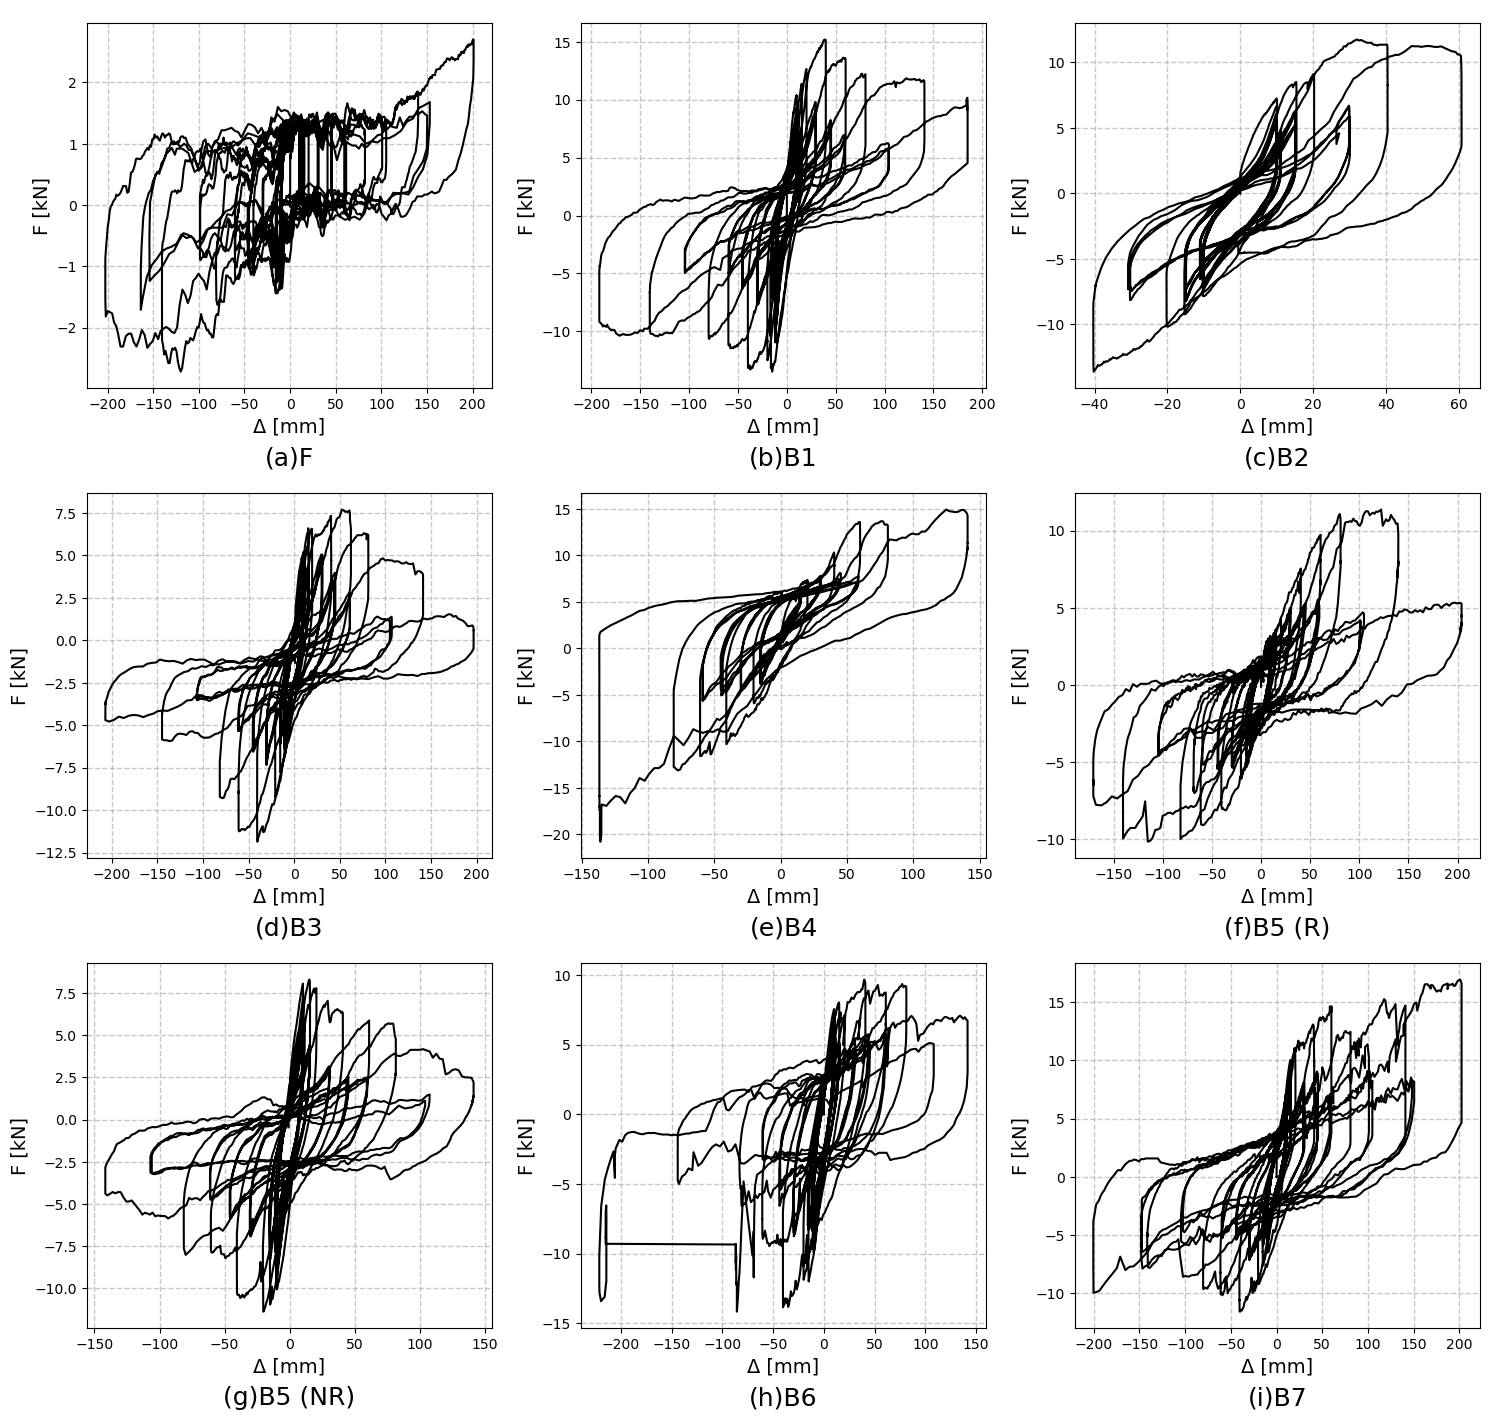

In [93]:
# Número de hojas
n_sheets = len(sheet_names)

# Definimos cuántas columnas deseamos (por ejemplo, 3)
ncols = 3
# Calculamos cuántas filas necesitamos
nrows = math.ceil(n_sheets / ncols)

# Creamos la figura y los subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows), sharex=False, sharey=False)

# Si solo hay una fila, axes podría no ser un array 2D, así que aplanamos para facilitar el indexado
axes = axes.flatten() if n_sheets > 1 else [axes]

for i, sheet in enumerate(sheet_names):
    # Leemos la hoja correspondiente
    df = pd.read_excel(
        file_name,
        sheet_name=sheet,
        usecols=[3,4,6],
        header=None,
        names=["Time(s)", "Force(kN)", "Displacement(mm)"],
        skiprows=9
    )
    df["Displacement(mm)"] = -df["Displacement(mm)"]
    
    # Graficamos Fuerza vs. Desplazamiento (histeresis)
    axes[i].plot(df["Displacement(mm)"], df["Force(kN)"], color='black')
    axes[i].set_title(' ', fontsize=5)
    axes[i].set_xlabel("Δ [mm]", fontsize=14)
    axes[i].set_ylabel("F [kN]", fontsize=14)
    axes[i].grid(which='both', linestyle='--', linewidth=1, alpha=0.7)

    # Agregamos el "título" abajo en cada subplot
    nuevo_titulo = nuevos_nombres.get(sheet, sheet)
    axes[i].text(0.5, -0.21, nuevo_titulo, transform=axes[i].transAxes, fontsize=18, ha='center')

# Si sobran subplots (cuando el número de hojas no es múltiplo de ncols),
# los ocultamos para que no aparezcan vacíos
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('my_high_quality_figure.pdf', dpi=600, bbox_inches='tight')
plt.savefig('my_high_quality_figure.jpg', dpi=600, bbox_inches='tight')
plt.show()



In [96]:
def envelope_min_max(df, disp_col="Displacement(mm)", force_col="Force(kN)", step=2.0):
    """
    Builds an 'outer envelope' by:
      1) Sorting the data by displacement.
      2) Defining displacement bins of width `step`.
      3) For each bin, finding the maximum force and the minimum force.
    Returns two DataFrames: 
      - top_df  (displacement vs. max force)
      - bot_df  (displacement vs. min force)
    so you can plot the upper and lower boundaries separately.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Your hysteresis data.
    disp_col : str
        Column name for displacement.
    force_col : str
        Column name for force.
    step : float
        Bin size in displacement units. Smaller step -> finer envelope, but more sensitive to noise.
    """
    # Sort by displacement
    df_sorted = df.sort_values(by=disp_col).reset_index(drop=True)

    # Determine the displacement range
    disp_min = df_sorted[disp_col].min()
    disp_max = df_sorted[disp_col].max()

    # Create bins (center points) from disp_min to disp_max in increments of `step`
    bins = np.arange(disp_min, disp_max + step, step)
    half_step = step / 2.0

    # Lists to hold top (max) and bottom (min) envelope points
    disp_top, force_top = [], []
    disp_bot, force_bot = [], []

    # For each bin, find max force and min force
    for center in bins:
        lower = center - half_step
        upper = center + half_step
        
        # Subset of points in this bin
        subset = df_sorted[(df_sorted[disp_col] >= lower) & (df_sorted[disp_col] < upper)]
        if len(subset) == 0:
            continue  # No data in this bin, skip

        # Max and min force in this bin
        max_force = subset[force_col].max()
        min_force = subset[force_col].min()

        disp_top.append(center)
        force_top.append(max_force)

        disp_bot.append(center)
        force_bot.append(min_force)

    # Build separate DataFrames for top and bottom envelopes
    top_df = pd.DataFrame({disp_col: disp_top, force_col: force_top})
    bot_df = pd.DataFrame({disp_col: disp_bot, force_col: force_bot})

    return top_df, bot_df

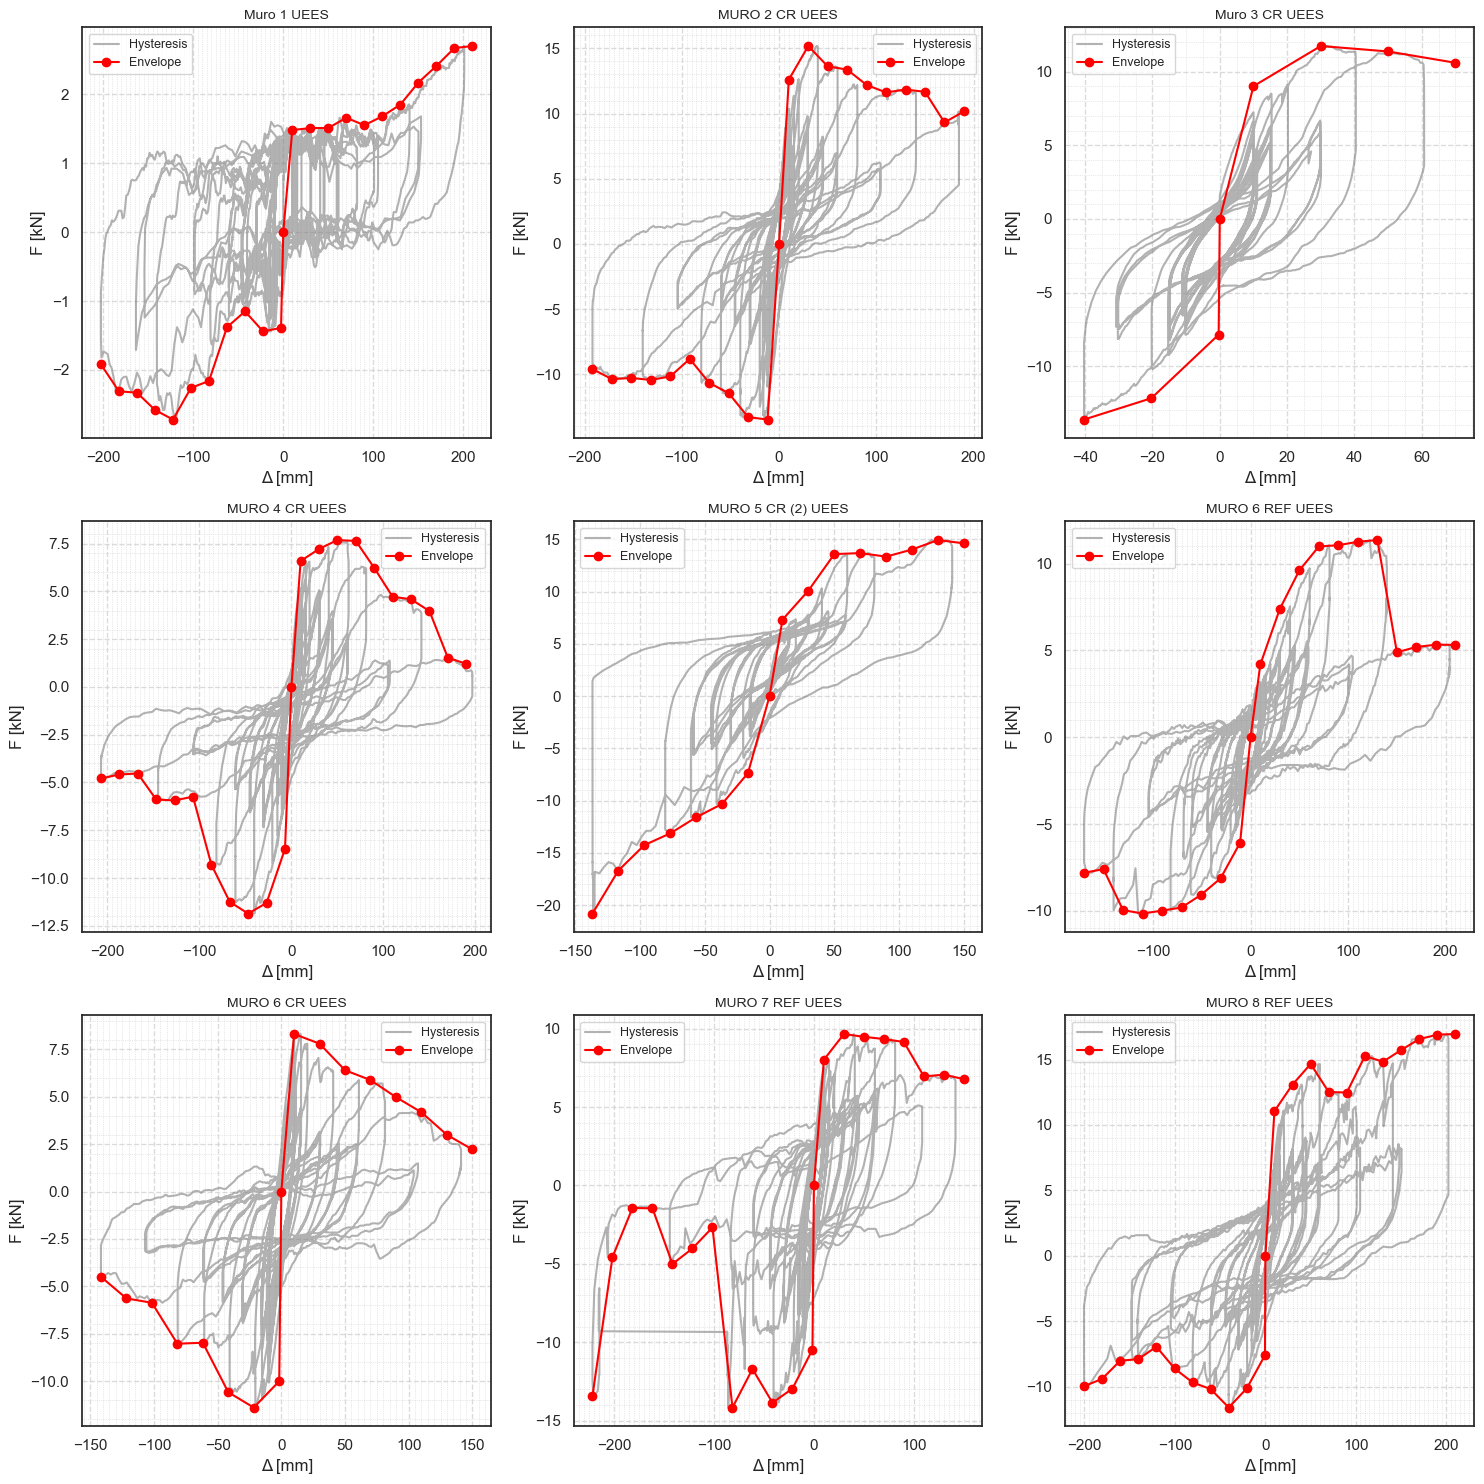

In [214]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

# Define how large the band around zero we want to ignore
EPS = 10.0

for i, sheet in enumerate(sheet_names):
    # Read data
    df = pd.read_excel(
        file_name,
        sheet_name=sheet,
        usecols=[3,4,6],
        header=None,
        names=["Time(s)", "Force(kN)", "Displacement(mm)"],
        skiprows=9
    )
    
    # Optionally invert displacement if needed
    df["Displacement(mm)"] = -df["Displacement(mm)"]

    # Plot the full hysteresis in gray
    axes[i].plot(
        df["Displacement(mm)"], 
        df["Force(kN)"], 
        color='gray', alpha=0.6, label='Hysteresis'
    )

    # ------------------------------------------
    #  A) Split data by displacement
    # ------------------------------------------
    df_neg = df[df["Displacement(mm)"] < -EPS].copy()
    df_pos = df[df["Displacement(mm)"] >  EPS].copy()
    df_mid = df[(df["Displacement(mm)"] >= -EPS) & (df["Displacement(mm)"] <= EPS)].copy()

    # Build min/max envelopes for negative side (df_neg) and positive side (df_pos)
    top_df_neg, bot_df_neg = envelope_min_max(df_neg, step=20.0)
    top_df_pos, bot_df_pos = envelope_min_max(df_pos, step=20.0)

    # For negative side, we keep the bottom envelope (min forces)
    neg_envelope = bot_df_neg.copy()
    # For positive side, we keep the top envelope (max forces)
    pos_envelope = top_df_pos.copy()

    # ------------------------------------------
    #  B) Create a single "mid" point
    # ------------------------------------------
    # Option 1: Force it to (0,0)
    mid_disp, mid_force = 0.0, 0.0

    # Option 2 (alternative): Use the average or median from df_mid
    # if not df_mid.empty:
    #     mid_disp = df_mid["Displacement(mm)"].mean()  # or median()
    #     mid_force = df_mid["Force(kN)"].mean()

    # We'll stick to forcibly (0,0) for your request:
    
    # Insert that mid point into each side
    neg_envelope.loc[-1] = [0.0, 0.0]
    pos_envelope.loc[-1] = [0.0, 0.0]

    # Sort them by displacement
    neg_envelope.sort_values(by="Displacement(mm)", inplace=True)
    pos_envelope.sort_values(by="Displacement(mm)", inplace=True)

    # ------------------------------------------
    #  C) Concatenate negative + positive
    # ------------------------------------------
    # The negative side will go from negative displacement up to (0,0).
    # The positive side will go from (0,0) out to positive displacement.
    combined_df = pd.concat([neg_envelope, pos_envelope], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.sort_values(by="Displacement(mm)", inplace=True)

    # ------------------------------------------
    #  D) Plot the final combined envelope
    # ------------------------------------------
    axes[i].plot(
        combined_df["Displacement(mm)"],
        combined_df["Force(kN)"],
        color='red', marker='o', label='Envelope'
    )

    # Style
    axes[i].set_title(sheet, fontsize=10)
    axes[i].set_xlabel("Δ [mm]", fontsize=12)
    axes[i].set_ylabel("F [kN]", fontsize=12)
    axes[i].grid(True, which='both', linestyle='--', alpha=0.7)
    axes[i].legend(fontsize=9)

    # Enable minor ticks
    axes[i].minorticks_on()
    # Set spacing for major and minor ticks on x-axis
    #axes[i].xaxis.set_major_locator(MultipleLocator(10))  # major ticks every 20 units
    axes[i].xaxis.set_minor_locator(MultipleLocator(5))   # minor ticks every 5 units
    # Set spacing for major and minor ticks on y-axis
    #axes[i].yaxis.set_major_locator(MultipleLocator(2))
    axes[i].yaxis.set_minor_locator(MultipleLocator(1))
    # Optional: customize the minor grid
    axes[i].grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.85)

# Hide extra subplots if any
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig('custom_envelope_ignoring_zero.pdf', dpi=300, bbox_inches='tight')
plt.savefig('custom_envelope_ignoring_zero.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [98]:
from scipy.stats import linregress

def yield_offset_method(df, disp_col="Displacement", force_col="Force",
                        offset=2.0):
    """
    Finds yield point by:
      1) Identifying initial linear region and regressing to find slope K0.
      2) Shifting that line by `offset` in displacement.
      3) Intersecting the offset line with the actual curve.
    
    Parameters
    ----------
    offset : float
        The displacement offset in the same units as disp_col (e.g., mm).
        Example: offset=2 mm, or offset=0.2 mm, etc.

    Returns
    -------
    (Fy, dy): Force and displacement at yield.
    """
    # 1) Identify initial linear region
    #    Here we pick up to 70% of Fmax as an example
    Fmax = df[force_col].max()
    cutoff = 0.7 * Fmax
    linear_df = df[df[force_col] <= cutoff]

    # 2) Linear regression on that region
    slope, intercept, r_value, p_value, std_err = linregress(
        linear_df[disp_col], linear_df[force_col]
    )
    K0 = slope  # initial stiffness
    # optional: intercept might be near zero

    # 3) Build the offset line: F_offset = K0*(d - offset)
    #    We'll find intersection numerically by scanning the data
    #    (A more robust approach might do interpolation or root-finding.)
    df_copy = df.copy()
    df_copy["OffsetLine"] = K0 * (df_copy[disp_col] - offset)

    # 4) Intersection -> where Force == OffsetLine
    #    We'll look for sign changes in (Force - OffsetLine)
    df_copy["Diff"] = df_copy[force_col] - df_copy["OffsetLine"]

    # sign change indicates crossing
    sign_change = df_copy["Diff"].values[:-1] * df_copy["Diff"].values[1:] < 0
    crossing_indices = np.where(sign_change)[0]

    if len(crossing_indices) == 0:
        # No intersection found (offset too large?), return None or fallback
        return None, None

    # Just take the first intersection
    idx = crossing_indices[0]
    # Interpolate linearly between idx and idx+1
    x1 = df_copy[disp_col].iloc[idx]
    x2 = df_copy[disp_col].iloc[idx+1]
    y1 = df_copy["Diff"].iloc[idx]
    y2 = df_copy["Diff"].iloc[idx+1]
    # fraction of the way
    frac = abs(y1) / (abs(y1) + abs(y2))
    dy = x1 + frac * (x2 - x1)

    # Force at that intersection = offset line or actual curve (they match)
    Fy = K0 * (dy - offset)

    return Fy, dy

In [99]:
def yield_tangent_intersection(df, disp_col="Displacement", force_col="Force"):
    """
    Finds yield by intersection of two tangents:
      - Tangent #1: initial (0 to ~70% of Fmax)
      - Tangent #2: final (~70% of Fmax to ~end)
    Returns (Fy, dy).
    """
    Fmax = df[force_col].max()
    cutoff_low = 0.1 * Fmax
    cutoff_high = 0.8 * Fmax

    # Tangent #1: regress from near 0 up to 0.7 Fmax
    df_t1 = df[df[force_col] <= cutoff_high]
    slope1, intercept1, *_ = linregress(df_t1[disp_col], df_t1[force_col])

    # Tangent #2: regress from 0.7 Fmax to near Fmax
    df_t2 = df[df[force_col] >= cutoff_low]
    slope2, intercept2, *_ = linregress(df_t2[disp_col], df_t2[force_col])

    # Intersection of lines:
    # slope1 * d + intercept1 = slope2 * d + intercept2
    # => (slope1 - slope2)*d = intercept2 - intercept1
    denom = (slope1 - slope2)
    if abs(denom) < 1e-12:
        return None, None
    dy = (intercept2 - intercept1) / denom
    Fy = slope1*dy + intercept1

    return Fy, dy

In [100]:
def yield_derivative_based(df, disp_col="Displacement", force_col="Force",
                           fraction=0.5):
    """
    Example: define yield where dF/dδ = fraction * (initial slope).
    fraction=0.5 => half the initial stiffness.
    """
    from numpy import gradient

    # 1) initial slope ~ linear regression on first portion
    Fmax = df[force_col].max()
    cutoff = 0.7 * Fmax
    linear_df = df[df[force_col] <= cutoff]
    slope_init, intercept, *_ = linregress(linear_df[disp_col], linear_df[force_col])

    # 2) numeric derivative
    disp_vals = df[disp_col].values
    force_vals = df[force_col].values
    dF_dD = gradient(force_vals, disp_vals)  # approximate derivative

    # 3) find where derivative ~ fraction*slope_init
    target_slope = fraction * slope_init
    df_copy = df.copy()
    df_copy["dF_dD"] = dF_dD
    df_copy["Diff"] = df_copy["dF_dD"] - target_slope

    # sign changes => crossing
    sign_change = df_copy["Diff"].values[:-1] * df_copy["Diff"].values[1:] < 0
    crossing_indices = np.where(sign_change)[0]
    if len(crossing_indices) == 0:
        return None, None

    idx = crossing_indices[0]
    # Simple linear interpolation in derivative space
    x1 = disp_vals[idx]
    x2 = disp_vals[idx+1]
    y1 = df_copy["Diff"].iloc[idx]
    y2 = df_copy["Diff"].iloc[idx+1]
    frac = abs(y1)/(abs(y1)+abs(y2))
    dy = x1 + frac*(x2 - x1)
    Fy = np.interp(dy, disp_vals, force_vals)

    return Fy, dy

In [107]:
from scipy.stats import linregress

# ---------------------------
# 1. Envelope Function
# ---------------------------
def envelope_min_max(df, disp_col="Displacement(mm)", force_col="Force(kN)", step=20.0):
    """
    Bins the data by displacement and returns:
      - top_df: for each bin, the maximum force (upper envelope)
      - bot_df: for each bin, the minimum force (lower envelope)
    """
    df_sorted = df.sort_values(by=disp_col).reset_index(drop=True)
    disp_min = df_sorted[disp_col].min()
    disp_max = df_sorted[disp_col].max()
    bins = np.arange(disp_min, disp_max + step, step)
    half_step = step / 2.0

    disp_top, force_top = [], []
    disp_bot, force_bot = [], []
    for center in bins:
        lower = center - half_step
        upper = center + half_step
        subset = df_sorted[(df_sorted[disp_col] >= lower) & (df_sorted[disp_col] < upper)]
        if subset.empty:
            continue
        disp_top.append(center)
        force_top.append(subset[force_col].max())
        disp_bot.append(center)
        force_bot.append(subset[force_col].min())
        
    top_df = pd.DataFrame({disp_col: disp_top, force_col: force_top})
    bot_df = pd.DataFrame({disp_col: disp_bot, force_col: force_bot})
    return top_df, bot_df

# ---------------------------
# 2. Analysis Function (Placeholder)
# ---------------------------
def analyze_envelope_method(envelope_df, method="offset"):
    if envelope_df.empty:
        return None, None, None, None, None, None, None
    
    if method == "offset":
        # Implement the Offset Method:
        # e.g., calculate initial stiffness, build offset line, find intersection, etc.
        Fy, dy = yield_offset_method(envelope_df, disp_col="Displacement(mm)", force_col="Force(kN)", offset=2.0)
    elif method == "tangent":
        # Implement the Tangent Intersection Method:
        Fy, dy = yield_tangent_intersection(envelope_df, disp_col="Displacement(mm)", force_col="Force(kN)")
    elif method == "derivative":
        # Implement the Derivative-Based Method:
        Fy, dy = yield_derivative_based(envelope_df, disp_col="Displacement(mm)", force_col="Force(kN)", fraction=0.5)
    else:
        Fy, dy = None, None

    # For all methods, we extract the peak and ultimate points as before:
    peak_idx = envelope_df["Force(kN)"].idxmax()
    Fm = envelope_df["Force(kN)"].loc[peak_idx]
    dm = envelope_df["Displacement(mm)"].loc[peak_idx]
    
    target = 0.8 * Fm
    df_after_peak = envelope_df[envelope_df["Displacement(mm)"] >= dm]
    cond = df_after_peak["Force(kN)"] <= target
    if cond.any():
        ult_idx = df_after_peak[cond].index[0]
        Fu = df_after_peak["Force(kN)"].loc[ult_idx]
        du = df_after_peak["Displacement(mm)"].loc[ult_idx]
    else:
        Fu, du = None, None

    mu = du / dy if (dy is not None and dy != 0 and du is not None) else None
    return Fy, dy, Fm, dm, Fu, du, mu



In [108]:
methods = ["offset", "tangent", "derivative"]

# -------------------------------------
# 2) Prepare a dict for storing results
# -------------------------------------
results_data = {
    "Curve": [],
    "Method": [],
    "Fy (kN)": [],
    "dy (mm)": [],
    "Fm (kN)": [],
    "dm (mm)": [],
    "Fu (kN)": [],
    "du (mm)": [],
    "μ": []
}


In [109]:
for sheet in sheet_names:
    # Split into positive and negative parts
    df_pos = df[df["Displacement(mm)"] >= 0].copy()
    df_neg = df[df["Displacement(mm)"] < 0].copy()

    # Compute envelopes for positive side and negative side
    top_df_pos, bot_df_pos = envelope_min_max(df_pos, step=2.0)
    top_df_neg, bot_df_neg = envelope_min_max(df_neg, step=2.0)

    # For positive side, use the top envelope (max forces)
    pos_envelope = top_df_pos.copy()
    # For negative side, use the bottom envelope (min forces)
    neg_envelope = bot_df_neg.copy()

    # Force the envelopes to connect at (0,0)
    pos_envelope.loc[-1] = [0.0, 0.0]
    neg_envelope.loc[-1] = [0.0, 0.0]
    pos_envelope.sort_values(by="Displacement(mm)", inplace=True)
    neg_envelope.sort_values(by="Displacement(mm)", inplace=True)

    # Combine the negative and positive envelopes into one continuous envelope
    combined_envelope = pd.concat([neg_envelope, pos_envelope], ignore_index=True)
    combined_envelope.drop_duplicates(inplace=True)
    combined_envelope.sort_values(by="Displacement(mm)", inplace=True)
    
    # Iterate over the three analysis methods
    for method in methods:
        Fy, dy, Fm, dm, Fu, du, mu = analyze_envelope_method(combined_envelope, method=method)
        
        results_data["Curve"].append(sheet)
        results_data["Method"].append(method.capitalize())
        results_data["Fy (kN)"].append(Fy)
        results_data["dy (mm)"].append(dy)
        results_data["Fm (kN)"].append(Fm)
        results_data["dm (mm)"].append(dm)
        results_data["Fu (kN)"].append(Fu)
        results_data["du (mm)"].append(du)
        results_data["μ"].append(mu)

# Convert results into a DataFrame (one row per curve & method)
results_df = pd.DataFrame(results_data)

# Optionally, round the values for cleaner reporting
results_df = results_df.round(2)

print(results_df)
results_df.to_excel("curves_envelope_analysis.xlsx", index=False)

C:\Users\jpmol\anaconda3\envs\Structural\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\jpmol\anaconda3\envs\Structural\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\jpmol\anaconda3\envs\Structural\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Users\jpmol\anaconda3\envs\Structural\Lib\site-packages\numpy\lib\function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
C:\Users\jpmol\anaconda3\envs\Structural\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\jpmol\anaconda3\envs\Structural\Lib\site-pack

                 Curve      Method  Fy (kN)  dy (mm)  Fm (kN)  dm (mm)  \
0          Muro 1 UEES      Offset    -7.63  -140.64    16.95    200.0   
1          Muro 1 UEES     Tangent    17.47   210.31    16.95    200.0   
2          Muro 1 UEES  Derivative    -3.20  -198.44    16.95    200.0   
3       MURO 2 CR UEES      Offset    -7.63  -140.64    16.95    200.0   
4       MURO 2 CR UEES     Tangent    17.47   210.31    16.95    200.0   
5       MURO 2 CR UEES  Derivative    -3.20  -198.44    16.95    200.0   
6       Muro 3 CR UEES      Offset    -7.63  -140.64    16.95    200.0   
7       Muro 3 CR UEES     Tangent    17.47   210.31    16.95    200.0   
8       Muro 3 CR UEES  Derivative    -3.20  -198.44    16.95    200.0   
9       MURO 4 CR UEES      Offset    -7.63  -140.64    16.95    200.0   
10      MURO 4 CR UEES     Tangent    17.47   210.31    16.95    200.0   
11      MURO 4 CR UEES  Derivative    -3.20  -198.44    16.95    200.0   
12  MURO 5 CR (2) UEES      Offset    

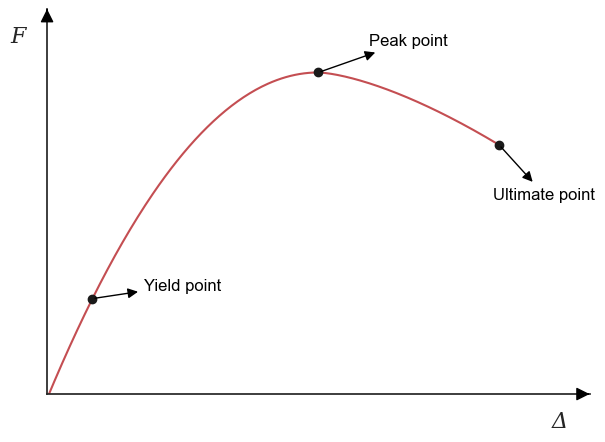

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn white theme
sns.set_theme(style="white")

# Displacement values (0 to 10)
displacement = np.linspace(0, 10, 300)

# Define constants for a smooth piecewise load–displacement curve:
B = 36.0  # Peak force at d=6
C = 2.0   # Coefficient for Region 2
M = 2.0   # Coefficient for Region 3
A = 1.0   # Quadratic coefficient for Region 1; chosen for continuity at d=2

force = np.zeros_like(displacement)
for i, d in enumerate(displacement):
    if d <= 2:
        force[i] = B - C * (6 - d)**2
    elif d <= 6:
        force[i] = B - C * (6 - d)**2
    else:
        force[i] = B - M * (d - 6)**1.5

# Define special points (example positions)
yield_disp = 1.0
yield_idx  = np.argmin(np.abs(displacement - yield_disp))
yield_force = force[yield_idx]

peak_disp = 6.0
peak_idx  = np.argmin(np.abs(displacement - peak_disp))
peak_force = force[peak_idx]

ultimate_disp = 10.0
ultimate_idx  = np.argmin(np.abs(displacement - ultimate_disp))
ultimate_force = force[ultimate_idx]

# Define arrow offset variables to control arrow length:
offset_yield = (2.0, 2)     # (x offset, y offset) for Yield annotation
offset_peak = (2, 6)         # for Peak annotation
offset_ultimate = (1.0, -12)  # for Ultimate annotation

# Define arrow properties with increased mutation_scale (for arrow head size)
arrow_props_blue = dict(arrowstyle="<|-", color='black', lw=1, mutation_scale=15)
arrow_props_green = dict(arrowstyle="<|-", color='black', lw=1, mutation_scale=15)
arrow_props_black = dict(arrowstyle="<|-", color='black', lw=1, mutation_scale=15)

plt.figure(figsize=(7,5))
plt.plot(displacement, force, 'r-', label='Load–Displacement')
plt.plot(yield_disp, yield_force, 'ko')
plt.plot(peak_disp, peak_force, 'ko')
plt.plot(ultimate_disp, ultimate_force, 'ko')

# Annotate special points with arrows; adjust xytext for arrow length
plt.annotate('Yield point', xy=(yield_disp, yield_force), 
             xytext=(yield_disp + offset_yield[0], yield_force + offset_yield[1]),
             arrowprops=arrow_props_blue, color='black', ha='center')

plt.annotate('Peak point', xy=(peak_disp, peak_force), 
             xytext=(peak_disp + offset_peak[0], peak_force + offset_peak[1]),
             arrowprops=arrow_props_green, color='black', ha='center')

plt.annotate('Ultimate point', xy=(ultimate_disp, ultimate_force), 
             xytext=(ultimate_disp + offset_ultimate[0], ultimate_force + offset_ultimate[1]),
             arrowprops=arrow_props_black, color='black', ha='center')

# Remove default ticks
plt.xticks([])
plt.yticks([])

# Remove upper and right spines
sns.despine()

# Remove default axis labels and add custom ones near the arrow tips of bottom and left spines
plt.xlabel('')
plt.ylabel('')
plt.text(0.93, -0.07, 'Δ', transform=plt.gca().transAxes,
         fontsize=16, fontstyle='italic', fontweight='medium', fontfamily='serif', rotation=0, va='center', ha='left')
plt.text(-0.04, 0.93, 'F', transform=plt.gca().transAxes,
         fontsize=16, fontstyle='italic', fontweight='medium', fontfamily='serif', rotation=0, va='center', ha='right')

# Add arrow annotations for the bottom and left spines with larger arrows
plt.annotate('', xy=(1, 0), xytext=(0.99, 0), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="-|>", color='black', lw=1, mutation_scale=20))
plt.annotate('', xy=(0, 1), xytext=(0, 0.99), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="-|>", color='black', lw=1, mutation_scale=20))

plt.xlim(0, 12)
plt.ylim(-35, 50)
plt.title('')
#plt.legend()
plt.savefig('envelope_points.jpg', dpi=300, bbox_inches='tight')
plt.show()


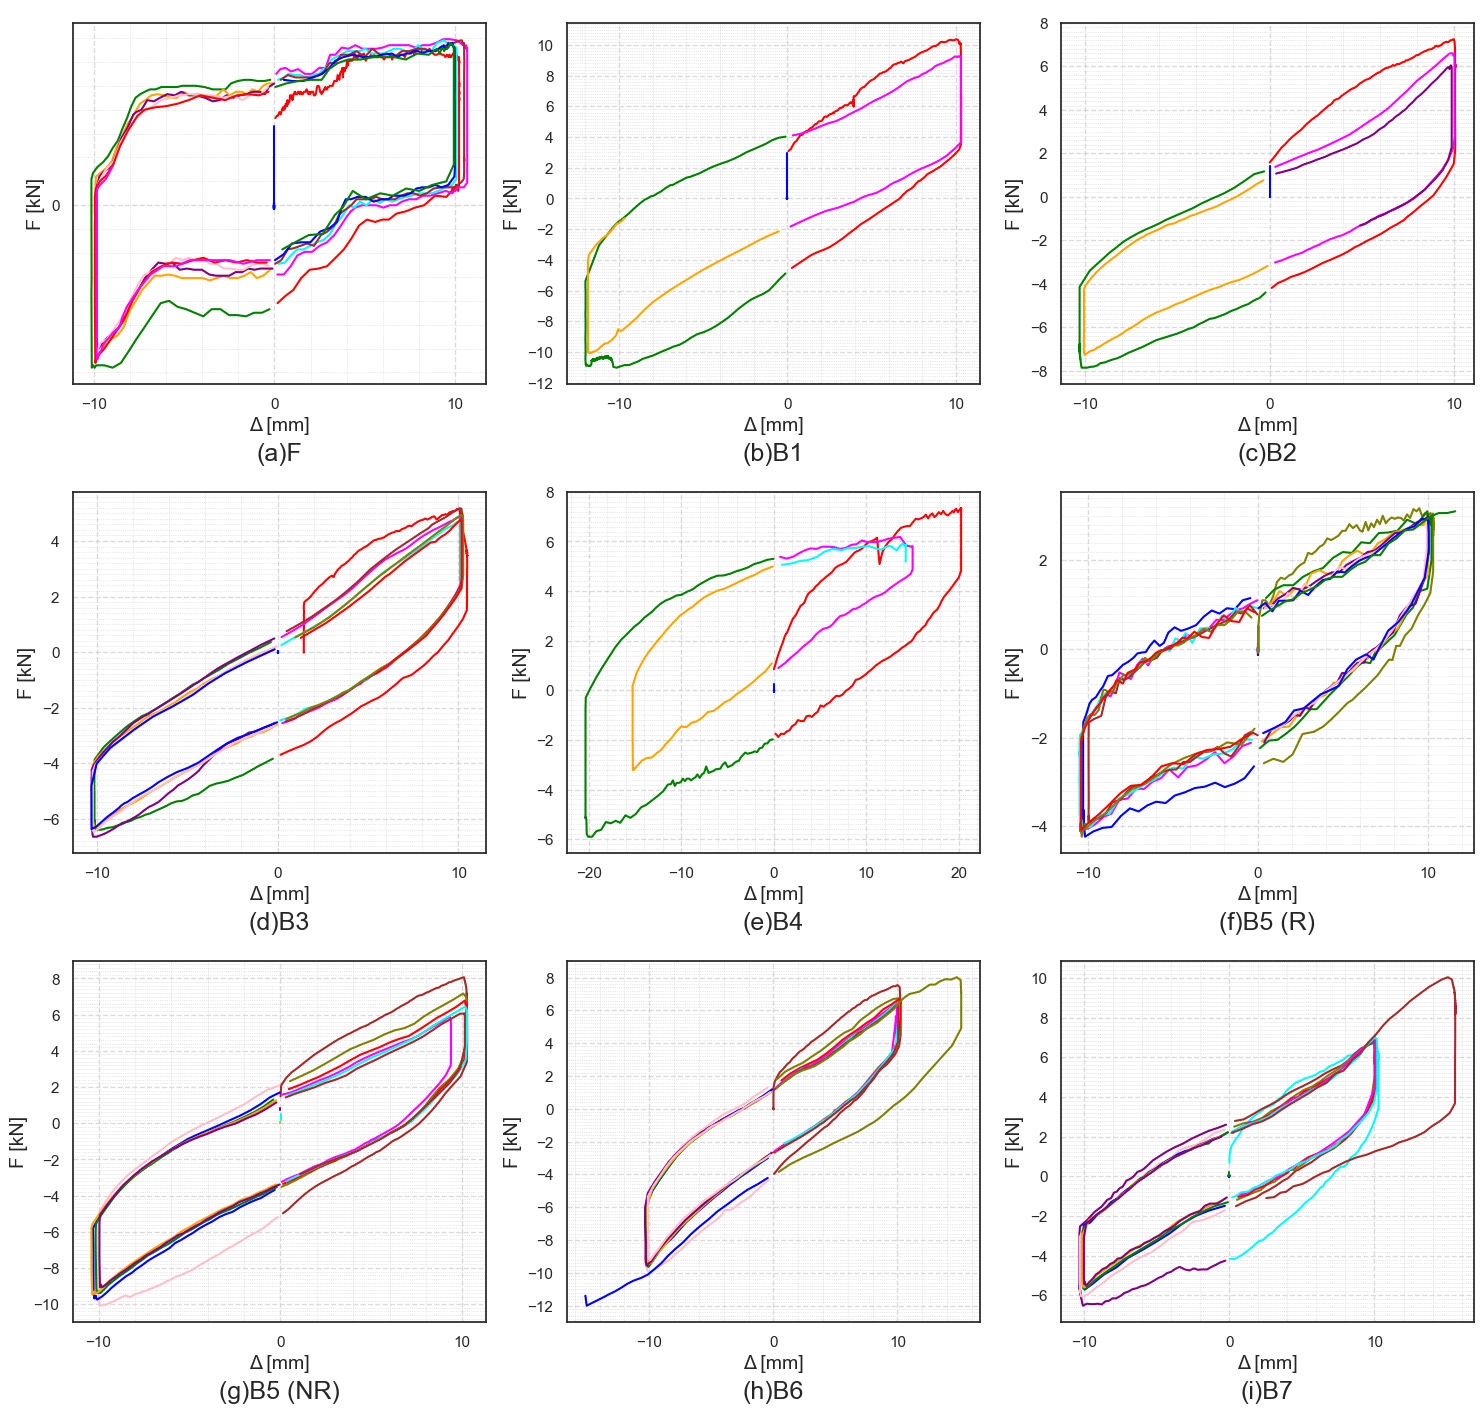

In [212]:
from matplotlib.ticker import MultipleLocator

# Assume sheet_names and nuevos_nombres are defined as before:
sheet_names = ['Muro 1 UEES', 'MURO 2 CR UEES', 'Muro 3 CR UEES', 
               'MURO 4 CR UEES', 'MURO 5 CR (2) UEES', 'MURO 6 REF UEES',
               'MURO 6 CR UEES', 'MURO 7 REF UEES', 'MURO 8 REF UEES']

# Diccionario con los nuevos nombres para los títulos de cada gráfico
nuevos_nombres = {
    'Muro 1 UEES': '(a)F',
    'MURO 2 CR UEES': '(b)B1',
    'Muro 3 CR UEES': '(c)B2',
    'MURO 4 CR UEES': '(d)B3',
    'MURO 5 CR (2) UEES': '(e)B4',
    'MURO 6 REF UEES': '(f)B5 (R)',
    'MURO 6 CR UEES': '(g)B5 (NR)',
    'MURO 7 REF UEES': '(h)B6',
    'MURO 8 REF UEES': '(i)B7'
}

# Set a variable to cap the number of data points to plot
cap = 1000

# Número de hojas
n_sheets = len(sheet_names)
# Definimos cuántas columnas deseamos (por ejemplo, 3)
ncols = 3
# Calculamos cuántas filas necesitamos
nrows = math.ceil(n_sheets / ncols)

# Creamos la figura y los subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows), sharex=False, sharey=False)
axes = axes.flatten() if n_sheets > 1 else [axes]

# Define a list of colors to cycle through for each cycle segment
colors = ['blue', 'red', 'green', 'magenta', 'orange', 'cyan', 'purple', 'brown', 'pink', 'olive']

for i, sheet in enumerate(sheet_names):
    # Leemos la hoja correspondiente
    df = pd.read_excel(
        '1_12 Datos.xlsx',
        sheet_name=sheet,
        usecols=[3, 4, 6],
        header=None,
        names=["Time(s)", "Force(kN)", "Displacement(mm)"],
        skiprows=9
    )
    # Invertimos la dirección del desplazamiento si es necesario
    df["Displacement(mm)"] = -df["Displacement(mm)"]
    
    # Cap the data: if the DataFrame has more than 'cap' rows, take only the first 'cap' rows.
    if len(df) > cap:
        df = df.iloc[:cap]
    
    # Get displacement and force as numpy arrays for easier segmentation
    disp = df["Displacement(mm)"].values
    force = df["Force(kN)"].values

    # Find indices where the sign of displacement changes (zero crossings)
    zero_crossings = np.where(np.diff(np.sign(disp)) != 0)[0]
    
    # Split the data into segments based on zero crossings
    segments = []
    start_idx = 0
    for idx in zero_crossings:
        segments.append((start_idx, idx+1))
        start_idx = idx+1
    segments.append((start_idx, len(df)))  # add last segment

    # Plot each segment in a different color
    for j, (s, e) in enumerate(segments):
        col = colors[j % len(colors)]
        axes[i].plot(disp[s:e], force[s:e], color=col)
    
    # Set axis labels and grid lines
    axes[i].set_title(' ', fontsize=5)
    axes[i].set_xlabel("Δ [mm]", fontsize=14)
    axes[i].set_ylabel("F [kN]", fontsize=14)
    axes[i].grid(which='both', linestyle='--', linewidth=1, alpha=0.7)

    # Enable minor ticks
    axes[i].minorticks_on()
    # Set spacing for major and minor ticks on x-axis
    axes[i].xaxis.set_major_locator(MultipleLocator(10))  # major ticks every 20 units
    axes[i].xaxis.set_minor_locator(MultipleLocator(2))   # minor ticks every 5 units
    # Set spacing for major and minor ticks on y-axis
    axes[i].yaxis.set_major_locator(MultipleLocator(2))
    axes[i].yaxis.set_minor_locator(MultipleLocator(0.2))
    # Optional: customize the minor grid
    axes[i].grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.85)
    
    # Add the custom title below the plot
    nuevo_titulo = nuevos_nombres.get(sheet, sheet)
    axes[i].text(0.5, -0.21, nuevo_titulo, transform=axes[i].transAxes, fontsize=18, ha='center')

# Hide any extra subplots if necessary
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
#plt.savefig('my_high_quality_figure.pdf', dpi=600, bbox_inches='tight')
#plt.savefig('my_high_quality_figure.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [277]:
import pandas as pd
import numpy as np

# Parámetros
dy = 20.0  # desplazamiento yield en mm
tol = 0.5  # tolerancia en mm para considerar que se alcanzó el objetivo

# Definición de los desplazamientos objetivo: [-10dy, -7dy, -4dy, -3dy, -2dy, -dy, dy, 2dy, 3dy, 4dy, 7dy, 10dy]
multiplicadores = np.array([-10, -7, -4, -3, -2, -1, -0.75, -0.5, 0.5, 0.75, 1, 2, 3, 4, 7, 10])
objetivos = multiplicadores * dy  # por ejemplo: -200, -140, ..., -20, 20, 40, ... 200

# Lista de hojas (sheet names)
sheet_names = [
    'Muro 1 UEES', 'MURO 2 CR UEES', 'Muro 3 CR UEES', 
    'MURO 4 CR UEES', 'MURO 5 CR (2) UEES', 'MURO 6 REF UEES',
    'MURO 6 CR UEES', 'MURO 7 REF UEES', 'MURO 8 REF UEES'
]

# Nuevos nombres para las claves del diccionario final
nuevos_nombres = {
    'Muro 1 UEES': 'F',
    'MURO 2 CR UEES': 'B1',
    'Muro 3 CR UEES': 'B2',
    'MURO 4 CR UEES': 'B3',
    'MURO 5 CR (2) UEES': 'B4',
    'MURO 6 REF UEES': 'B5 (R)',
    'MURO 6 CR UEES': 'B5 (NR)',
    'MURO 7 REF UEES': 'B6',
    'MURO 8 REF UEES': 'B7'
}

# Diccionario para almacenar resultados.
# Cada key será el nuevo nombre del muro y cada value una matriz de 3 filas x 12 columnas,
# donde cada columna corresponde a uno de los desplazamientos objetivo.
force_dict = {}

# Para cada hoja
for sheet in sheet_names:
    # Lee el dataframe (ajusta según corresponda)
    df = pd.read_excel(
        '1_12 Datos.xlsx',
        sheet_name=sheet,
        usecols=[3, 4, 6],
        header=None,
        names=["Time(s)", "Force(kN)", "Displacement(mm)"],
        skiprows=9
    )
    
    # Invertir desplazamiento si es necesario
    df["Displacement(mm)"] = -df["Displacement(mm)"]
    
    # Se asume que los datos están ordenados cronológicamente.
    # Para cada desplazamiento objetivo, registraremos hasta 3 valores de fuerza (una por ciclo)
    # Utilizaremos un diccionario auxiliar: clave = valor objetivo, valor = lista de fuerzas
    target_forces = {obj: [] for obj in objetivos}
    
    # Para evitar registrar múltiples veces en puntos consecutivos, guardamos el índice del último registro para cada objetivo.
    last_recorded = {obj: -2 for obj in objetivos}
    
    # Iteramos sobre los datos (por cada fila)
    for idx, row in df.iterrows():
        disp_val = row["Displacement(mm)"]
        force_val = row["Force(kN)"]
        for obj in objetivos:
            # Si aún no tenemos 3 registros para este objetivo...
            if len(target_forces[obj]) < 3:
                # Si la diferencia entre el desplazamiento actual y el objetivo es menor o igual a tol
                if abs(disp_val - obj) <= tol:
                    # Solo se registra si no es un registro consecutivo (evita duplicados)
                    if idx - last_recorded[obj] > 1:
                        target_forces[obj].append(abs(force_val))
                        last_recorded[obj] = idx
    
    # Para cada objetivo, si no se encontraron 3 valores, se completan con np.nan
    force_matrix = []
    for obj in objetivos:
        forces = target_forces[obj]
        if len(forces) < 3:
            forces = forces + [np.nan]*(3 - len(forces))
        force_matrix.append(forces)
    # force_matrix es de dimensión (12, 3): transponemos para obtener (3, 12)
    force_array = np.array(force_matrix).T  # shape = (3, 12)
    
    # Almacenamos en el diccionario utilizando el nuevo nombre (clave)
    force_dict[nuevos_nombres[sheet]] = force_array

# Ejemplo de cómo visualizar los resultados para cada muro (clave del diccionario):
for key, matrix in force_dict.items():
    print(f"Resultados para {key}:")
    print(matrix)
    print("\n")


Resultados para F:
[[1.73 2.21 1.63 1.19 1.14 1.07 1.44 1.34 1.26 1.29 1.38 1.48 1.05 1.26
  1.85 2.67]
 [0.34 1.65 1.78 1.04 0.83 1.04 1.41 1.34 1.26 1.31 1.36 0.05 1.07 0.31
  1.82  nan]
 [ nan 1.6  0.88 0.85 0.54 0.97 0.15 1.34 1.24 1.27 1.36 1.32 1.04 0.31
  1.82  nan]]


Resultados para B1:
[[  nan  9.99 10.65 11.21 13.15 12.42 13.28 10.86 10.29 11.04 12.55 15.13
  13.55 12.09 11.63   nan]
 [  nan  9.62 10.38 10.82 12.88 12.33 13.4  11.03 10.34 11.24 12.64 14.72
  13.18 12.19  5.52   nan]
 [  nan  9.48 10.08 10.62 12.72 12.1  13.42 10.77 10.31 11.35 12.33 14.5
  13.01 11.82  1.56   nan]]


Resultados para B2:
[[  nan   nan   nan   nan 13.39 10.15  9.1   7.81  7.1   8.2   8.93 11.36
  10.61   nan   nan   nan]
 [  nan   nan   nan   nan 13.63 10.2   9.22  7.86  7.12  8.27  9.12 11.38
   3.23   nan   nan   nan]
 [  nan   nan   nan   nan 13.12 10.1   9.1   7.86  7.13  8.51  8.87 10.97
    nan   nan   nan   nan]]


Resultados para B3:
[[ 2.65  5.89  5.87 11.25 11.71  9.15  7.69  6.38  5

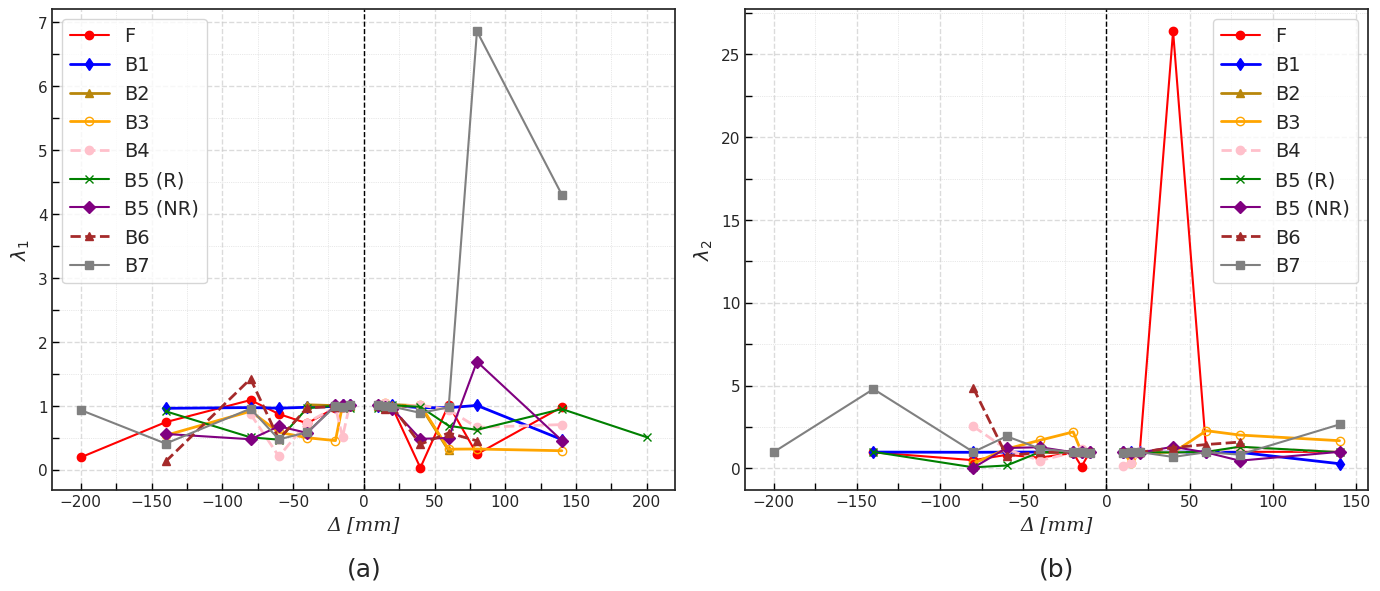

In [307]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Supongamos que ya tienes el diccionario force_dict generado anteriormente.
# force_dict tiene claves según nuevos_nombres y cada valor es una matriz de forma (3,12)
# donde cada columna corresponde a uno de los desplazamientos objetivo:
# [-10dy, -7dy, -4dy, -3dy, -2dy, -dy, dy, 2dy, 3dy, 4dy, 7dy, 10dy].

# Parámetros
dy = 20.0
multiplicadores = np.array([-10, -7, -4, -3, -2, -1, -0.75, -0.5, 0.5, 0.75, 1, 2, 3, 4, 7, 10])
objetivos = multiplicadores * dy   # Por ejemplo: [-200, -140, -80, -60, -40, -20, 20, 40, 60, 80, 140, 200]

# Ajusta color, marker, linestyle, etc., a tu gusto.
styles = {
    'F':       dict(color='red',    marker='o',  linestyle='-',  linewidth=1.5),
    'B1':      dict(color='blue',   marker='d',  linestyle='-',  linewidth=2),
    'B2':      dict(color='darkgoldenrod',   marker='^',  linestyle='-', linewidth=2),
    'B3':      dict(color='orange',   marker='o', fillstyle='none',  linestyle='-',  linewidth=2),
    'B4':      dict(color='pink', marker='o',  linestyle='--',  linewidth=2),
    'B5 (R)':  dict(color='green', marker='x',  linestyle='-',  linewidth=1.5),
    'B5 (NR)': dict(color='purple',  marker='D',  linestyle='-',  linewidth=1.5),
    'B6':      dict(color='brown',  marker='^',  linestyle='--',  linewidth=2),
    'B7':      dict(color='gray',   marker='s',  linestyle='-',  linewidth=1.5),
}

# Diccionarios para almacenar los valores de lambda para cada muro
lambda1_dict = {}  # λ₁ = (carga pico 2º ciclo) / (carga pico 1º ciclo)
lambda2_dict = {}  # λ₂ = (carga pico 3º ciclo) / (carga pico 2º ciclo)

# Recorremos cada muro en force_dict
for key, force_matrix in force_dict.items():
    # force_matrix: 3 filas (ciclos 1,2,3) x 12 columnas (objetivos de desplazamiento)
    # Calcular λ₁ y λ₂ para cada objetivo:
    lam1 = force_matrix[1, :] / force_matrix[0, :]  # 2º ciclo / 1º ciclo
    lam2 = force_matrix[2, :] / force_matrix[1, :]  # 3º ciclo / 2º ciclo
    
    lambda1_dict[key] = lam1
    lambda2_dict[key] = lam2

# Creamos la figura con 2 subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ajustamos el espacio horizontal entre subplots
# y un poco el 'bottom' para dar espacio al texto inferior.
plt.subplots_adjust(wspace=0.4, bottom=0.15)

ax1, ax2 = axes

# Línea vertical en x=0 en ambos subplots
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)

# ====== SUBPLOT IZQUIERDO: λ1 ======
for key, lam in lambda1_dict.items():
    style = styles.get(key, dict(color='black', marker='o', linestyle='-', linewidth=2))
    
    # Separar parte negativa y positiva de objetivos
    neg_mask = objetivos < 0
    pos_mask = objetivos > 0
    
    x_neg = objetivos[neg_mask]
    y_neg = lam[neg_mask]
    
    x_pos = objetivos[pos_mask]
    y_pos = lam[pos_mask]
    
    # Graficamos la parte negativa (sin label para no duplicar)
    if len(x_neg) > 0:
        ax1.plot(x_neg, y_neg, **style)
    # Graficamos la parte positiva con la leyenda
    if len(x_pos) > 0:
        ax1.plot(x_pos, y_pos, label=key, **style)

ax1.set_xlabel("Δ [mm]", fontsize=14, fontstyle='italic', fontweight='medium', fontfamily='serif')
ax1.set_ylabel(r"$\lambda_1$", fontsize=14, fontstyle='italic', fontweight='medium', fontfamily='serif')
ax1.grid(which='both', linestyle='--', linewidth=1, alpha=0.7)
ax1.legend(fontsize=14)
# Título abajo
ax1.text(0.5, -0.18, "(a)", transform=ax1.transAxes, ha='center', fontsize=18)

# ====== SUBPLOT DERECHO: λ2 ======
for key, lam in lambda2_dict.items():
    style = styles.get(key, dict(color='black', marker='o', linestyle='-', linewidth=2))
    
    neg_mask = objetivos < 0
    pos_mask = objetivos > 0
    
    x_neg = objetivos[neg_mask]
    y_neg = lam[neg_mask]
    
    x_pos = objetivos[pos_mask]
    y_pos = lam[pos_mask]
    
    if len(x_neg) > 0:
        ax2.plot(x_neg, y_neg, **style)
    if len(x_pos) > 0:
        ax2.plot(x_pos, y_pos, label=key, **style)

ax2.set_xlabel("Δ [mm]", fontsize=14, fontstyle='italic', fontweight='medium', fontfamily='serif')
ax2.set_ylabel(r"$\lambda_2$", fontsize=14, fontstyle='italic', fontweight='medium', fontfamily='serif')
ax2.grid(which='both', linestyle='--', linewidth=1, alpha=0.7)
ax2.legend(fontsize=14)
ax2.text(0.5, -0.18, "(b)", transform=ax2.transAxes, ha='center', fontsize=18)

# Ajuste de ticks
ax1.tick_params(axis='x', which='both', bottom=True, top=False)
ax1.tick_params(axis='y', which='both', left=True, right=False)
ax1.yaxis.set_minor_locator(MultipleLocator(0.5))  
ax1.xaxis.set_minor_locator(MultipleLocator(25))  
ax1.tick_params(axis='both', which='major', length=5, width=1, direction='in', color='black')
ax1.tick_params(axis='both', which='minor', length=5, width=1, direction='in', color='black')
ax1.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.85)

ax2.tick_params(axis='x', which='both', bottom=True, top=False)
ax2.tick_params(axis='y', which='both', left=True, right=False)
ax2.yaxis.set_minor_locator(MultipleLocator(2.5))  
ax2.xaxis.set_minor_locator(MultipleLocator(25))   
ax2.tick_params(axis='both', which='major', length=5, width=1, direction='in', color='black')
ax2.tick_params(axis='both', which='minor', length=5, width=1, direction='in', color='black')
ax2.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.85)


plt.tight_layout()
plt.savefig("degradacion_lambda_subplots.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [308]:
# 1) Primero, imprime los valores de λ1 y λ2
print("=== Valores de λ1 ===")
for key, lam in lambda1_dict.items():
    print(f"Muro: {key}")
    print("Desplazamientos:", objetivos)
    print("λ1:", lam)
    print()

print("=== Valores de λ2 ===")
for key, lam in lambda2_dict.items():
    print(f"Muro: {key}")
    print("Desplazamientos:", objetivos)
    print("λ2:", lam)
    print()

=== Valores de λ1 ===
Muro: F
Desplazamientos: [-200. -140.  -80.  -60.  -40.  -20.  -15.  -10.   10.   15.   20.   40.
   60.   80.  140.  200.]
λ1: [0.19653179 0.74660633 1.09202454 0.87394958 0.72807018 0.97196262
 0.97916667 1.         1.         1.01550388 0.98550725 0.03378378
 1.01904762 0.24603175 0.98378378        nan]

Muro: B1
Desplazamientos: [-200. -140.  -80.  -60.  -40.  -20.  -15.  -10.   10.   15.   20.   40.
   60.   80.  140.  200.]
λ1: [       nan 0.96296296 0.97464789 0.96520963 0.97946768 0.99275362
 1.00903614 1.01565378 1.00485909 1.01811594 1.00717131 0.97290152
 0.97269373 1.0082713  0.47463457        nan]

Muro: B2
Desplazamientos: [-200. -140.  -80.  -60.  -40.  -20.  -15.  -10.   10.   15.   20.   40.
   60.   80.  140.  200.]
λ1: [       nan        nan        nan        nan 1.01792382 1.00492611
 1.01318681 1.00640205 1.0028169  1.00853659 1.0212766  1.00176056
 0.30442978        nan        nan        nan]

Muro: B3
Desplazamientos: [-200. -140.  -80.  -60

In [305]:
# Número de objetivos:
N = len(objetivos)
# Suponiendo que el array es simétrico, se tienen pares negativos y positivos.
half = N // 2  # número de pares (en nuestro ejemplo 12/2 = 6)

# Los desplazamientos promedio (en valor absoluto) se obtienen tomando la mitad inferior del array (o superior, ambos son iguales)
disp_avg = np.abs(objetivos[:half])  # Por ejemplo, [20, 40, 60, 80, 140, 200] (según el ejemplo)

# Diccionarios para almacenar los valores promedio de lambda para cada muro.
lambda1_avg_dict = {}
lambda2_avg_dict = {}

# Para λ₁
for key, lam in lambda1_dict.items():
    avg_values = []
    for i in range(half):
        neg_val = lam[i]
        pos_val = lam[N - 1 - i]
        # Si ambos son NaN, se toma NaN
        if np.isnan(neg_val) and np.isnan(pos_val):
            avg = np.nan
        # Si uno de ellos es NaN, se toma el otro
        elif np.isnan(neg_val):
            avg = pos_val
        elif np.isnan(pos_val):
            avg = neg_val
        else:
            avg = (neg_val + pos_val) / 2.0
        avg_values.append(avg)
    lambda1_avg_dict[key] = np.array(avg_values)

# Para λ₂
for key, lam in lambda2_dict.items():
    avg_values = []
    for i in range(half):
        neg_val = lam[i]
        pos_val = lam[N - 1 - i]
        if np.isnan(neg_val) and np.isnan(pos_val):
            avg = np.nan
        elif np.isnan(neg_val):
            avg = pos_val
        elif np.isnan(pos_val):
            avg = neg_val
        else:
            avg = (neg_val + pos_val) / 2.0
        avg_values.append(avg)
    lambda2_avg_dict[key] = np.array(avg_values)

# ------------------------------------------------------------------------------
# Imprimir los resultados promedio de λ₁ y λ₂ por desplazamiento para cada muro
# ------------------------------------------------------------------------------
print("=== Valores Promedio de λ₁ por Desplazamiento (por muro) ===")
print("Desplazamientos promedio (mm):")
print(disp_avg)
print()
for key, avg_arr in lambda1_avg_dict.items():
    print(f"Muro: {key}")
    print("λ₁ promedio:", avg_arr)
    print("--------------------------------------------------\n")

print("=== Valores Promedio de λ₂ por Desplazamiento (por muro) ===")
print("Desplazamientos promedio (mm):")
print(disp_avg)
print()
for key, avg_arr in lambda2_avg_dict.items():
    print(f"Muro: {key}")
    print("λ₂ promedio:", avg_arr)
    print("--------------------------------------------------\n")

=== Valores Promedio de λ₁ por Desplazamiento (por muro) ===
Desplazamientos promedio (mm):
[200. 140.  80.  60.  40.  20.  15.  10.]

Muro: F
λ₁ promedio: [0.19653179 0.86519506 0.66902814 0.9464986  0.38092698 0.97873493
 0.99733527 1.        ]
--------------------------------------------------

Muro: B1
λ₁ promedio: [       nan 0.71879876 0.99145959 0.96895168 0.9761846  0.99996247
 1.01357604 1.01025643]
--------------------------------------------------

Muro: B2
λ₁ promedio: [       nan        nan        nan 0.30442978 1.00984219 1.01310135
 1.0108617  1.00460948]
--------------------------------------------------

Muro: B3
λ₁ promedio: [       nan 0.41982312 0.62161227 0.45627756 0.75841966 0.72120981
 1.02520156 1.00099404]
--------------------------------------------------

Muro: B4
λ₁ promedio: [       nan 0.70861833 0.76920399 0.57637963 0.87607046 0.98448814
 0.77841635 1.02187208]
--------------------------------------------------

Muro: B5 (R)
λ₁ promedio: [0.51136364 0.9

In [300]:
import pandas as pd
import numpy as np

# Parámetros globales
dy = 20.0                     # desplazamiento "yield" base en mm
tol = 0.5                     # tolerancia en mm
H_w = 2500.0                  # altura del muro en mm (para calcular la deriva)
L_w = 2500.0                  # longitud del muro en mm (para degradación de rigidez)

# Definición de los desplazamientos objetivo
multiplicadores = np.array([-10, -7, -4, -3, -2, -1, -0.75, -0.5, 0.5, 0.75, 1, 2, 3, 4, 7, 10])
objetivos = multiplicadores * dy   # Ejemplo: [-200, -140, -80, -60, -40, -20, 10, 15, 10, 15, 20, 40, 60, 80, 140, 200]
# Nota: Revisar los valores de multiplicadores para que tengan sentido (por ejemplo, en el lado positivo, -0.5 da -10 mm, pero según el ejemplo, 
# se asume que hay objetivos negativos y positivos; aquí se toma tal cual lo proporcionaste)

# Lista de hojas (nombres originales en el Excel)
sheet_names = [
    'Muro 1 UEES', 'MURO 2 CR UEES', 'Muro 3 CR UEES',
    'MURO 4 CR UEES', 'MURO 5 CR (2) UEES', 'MURO 6 REF UEES',
    'MURO 6 CR UEES', 'MURO 7 REF UEES', 'MURO 8 REF UEES'
]

# Nuevos nombres para las claves del diccionario final
nuevos_nombres = {
    'Muro 1 UEES': 'F',
    'MURO 2 CR UEES': 'B1',
    'Muro 3 CR UEES': 'B2',
    'MURO 4 CR UEES': 'B3',
    'MURO 5 CR (2) UEES': 'B4',
    'MURO 6 REF UEES': 'B5 (R)',
    'MURO 6 CR UEES': 'B5 (NR)',
    'MURO 7 REF UEES': 'B6',
    'MURO 8 REF UEES': 'B7'
}

# Diccionarios para almacenar los resultados:
# Cada uno tendrá como clave el nuevo nombre (F, B1, ...) y su valor será un array de 16 valores 
# (uno por cada desplazamiento objetivo) para la rigidez secante y la degradación de rigidez.
secant_stiffness_dict = {}
stiffness_degradation_dict = {}

# Archivo Excel (ajusta el nombre del archivo)
file_name = '1_12 Datos.xlsx'

# Para cada hoja (muro)
for sheet in sheet_names:
    # Lee el DataFrame de la hoja
    df = pd.read_excel(
        file_name,
        sheet_name=sheet,
        usecols=[3, 4, 6],
        header=None,
        names=["Time(s)", "Force(kN)", "Displacement(mm)"],
        skiprows=9
    )
    
    # Invertir el desplazamiento si es necesario
    df["Displacement(mm)"] = -df["Displacement(mm)"]
    
    # Se asume que los datos están ordenados cronológicamente.
    disp_vals = df["Displacement(mm)"].values
    force_vals = df["Force(kN)"].values
    
    k_sec_list = []   # para la rigidez secante en cada objetivo (kN/rad)
    k_deg_list = []   # para la degradación de rigidez en cada objetivo (kN/(m·rad))
    
    for obj in objetivos:
        # Filtrar datos en el rango [obj - tol, obj + tol]
        mask = (disp_vals >= (obj - tol)) & (disp_vals <= (obj + tol))
        subset_forces = force_vals[mask]
        
        if len(subset_forces) == 0:
            k_sec_list.append(np.nan)
            k_deg_list.append(np.nan)
        else:
            # Tomamos la fuerza máxima en valor absoluto
            Fmax = np.max(np.abs(subset_forces))
            
            # Calcular la deriva: drift = |obj| / H_w  (en rad, dado que para pequeñas deformaciones tan(θ)≈θ)
            drift = np.abs(obj) / H_w
            if drift < 1e-12:
                k_sec_list.append(np.nan)
                k_deg_list.append(np.nan)
            else:
                # Rigidez secante K_i = Fmax / drift  (kN/rad)
                K_i = Fmax / drift
                # Degradación de rigidez = K_i / (L_w en metros)
                K_deg = K_i / (L_w / 1000.0)  # L_w/1000 para pasar a m
                k_sec_list.append(K_i)
                k_deg_list.append(K_deg)
    
    # Convertir listas a arrays
    k_sec_array = np.array(k_sec_list)
    k_deg_array = np.array(k_deg_list)
    
    # Reemplazar la clave original por el nuevo nombre
    clave = nuevos_nombres[sheet]
    secant_stiffness_dict[clave] = k_sec_array
    stiffness_degradation_dict[clave] = k_deg_array

# ------------------------------------------------------------------------------
# Imprimir resultados (como se hizo con los λ)
# ------------------------------------------------------------------------------
print("=== Resultados de Rigidez Secante (kN/rad) y Degradación de Rigidez (kN/(m·rad)) ===\n")
print("Desplazamientos objetivo (mm):")
print(objetivos)
print("\n")

for muro in nuevos_nombres.values():
    print(f"Muro: {muro}")
    print("Rigidez Secante [kN/rad]:")
    print(secant_stiffness_dict[muro])
    print("Degradación de Rigidez [kN/(m·rad)]:")
    print(stiffness_degradation_dict[muro])
    print("--------------------------------------------------------\n")


=== Resultados de Rigidez Secante (kN/rad) y Degradación de Rigidez (kN/(m·rad)) ===

Desplazamientos objetivo (mm):
[-200. -140.  -80.  -60.  -40.  -20.  -15.  -10.   10.   15.   20.   40.
   60.   80.  140.  200.]


Muro: F
Rigidez Secante [kN/rad]:
[ 21.625       39.46428571  55.625       49.58333333  71.875
 155.         240.         382.5        360.         231.66666667
 176.25        93.125       62.08333333  46.5625      33.03571429
  33.75      ]
Degradación de Rigidez [kN/(m·rad)]:
[  8.65        15.78571429  22.25        19.83333333  28.75
  62.          96.         153.         144.          92.66666667
  70.5         37.25        24.83333333  18.625       13.21428571
  13.5       ]
--------------------------------------------------------

Muro: B1
Rigidez Secante [kN/rad]:
[          nan  178.39285714  332.8125      467.08333333  821.875
 1561.25       2245.         2900.         2595.         1893.33333333
 1580.          945.625       564.58333333  380.9375      208.3928

In [306]:
# Número total de objetivos
N = len(objetivos)
half = N // 2  # número de pares (por ejemplo, 12/2 = 6)

# Usamos los valores absolutos de los objetivos de la primera mitad para definir los desplazamientos promedio
disp_avg = np.abs(objetivos[:half])

# Diccionario para almacenar los promedios de degradación de rigidez para cada muro
avg_stiffness_deg_dict = {}

for key, k_deg in stiffness_degradation_dict.items():
    avg_values = []
    for i in range(half):
        neg_val = k_deg[i]
        pos_val = k_deg[N - 1 - i]
        # Si ambos son NaN, se asigna NaN
        if np.isnan(neg_val) and np.isnan(pos_val):
            avg = np.nan
        # Si uno es NaN, se toma el otro
        elif np.isnan(neg_val):
            avg = pos_val
        elif np.isnan(pos_val):
            avg = neg_val
        else:
            avg = (neg_val + pos_val) / 2.0
        avg_values.append(avg)
    avg_stiffness_deg_dict[key] = np.array(avg_values)

# ------------------------------------------------------------------------------
# Imprimir resultados promedio de degradación de rigidez (kN/(m·rad)) por desplazamiento
# ------------------------------------------------------------------------------
print("=== Valores Promedio de Degradación de Rigidez [kN/(m·rad)] por Desplazamiento (por muro) ===\n")
print("Desplazamientos promedio (mm):")
print(disp_avg)
print("\n")

for key, avg_arr in avg_stiffness_deg_dict.items():
    print(f"Muro: {key}")
    print("Degradación de Rigidez Promedio:")
    print(avg_arr)
    print("--------------------------------------------------------\n")

=== Valores Promedio de Degradación de Rigidez [kN/(m·rad)] por Desplazamiento (por muro) ===

Desplazamientos promedio (mm):
[200. 140.  80.  60.  40.  20.  15.  10.]


Muro: F
Degradación de Rigidez Promedio:
[ 11.075       14.5         20.4375      22.33333333  33.
  66.25        94.33333333 148.5       ]
--------------------------------------------------------

Muro: B1
Degradación de Rigidez Promedio:
[          nan   77.35714286  142.75        206.33333333  353.5
  628.25        827.66666667 1099.        ]
--------------------------------------------------------

Muro: B2
Degradación de Rigidez Promedio:
[         nan          nan          nan 176.83333333 312.625
 483.         592.         755.5       ]
--------------------------------------------------------

Muro: B3
Degradación de Rigidez Promedio:
[ 13.25        35.21428571  74.375      157.         239.75
 392.         492.33333333 601.        ]
--------------------------------------------------------

Muro: B4
Degradación 

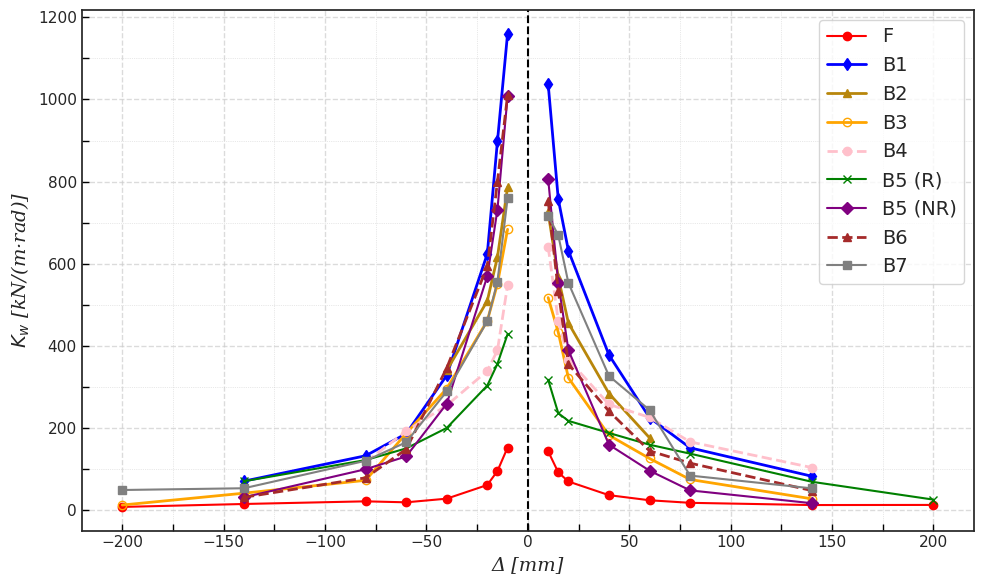

In [309]:
# Creamos la figura y el eje
fig, ax = plt.subplots(figsize=(10,6))

# Dibujamos la línea vertical en x=0 (desplazamiento=0)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)

for key, k_deg in stiffness_degradation_dict.items():
    style = styles.get(key, dict(color='black', marker='o', linestyle='-', linewidth=2))
    
    # Separamos las partes negativa y positiva de "objetivos"
    x = objetivos
    y = k_deg
    
    # Máscara para desplazamientos negativos
    neg_mask = (x < 0)
    x_neg = x[neg_mask]
    y_neg = y[neg_mask]
    
    # Máscara para desplazamientos positivos
    pos_mask = (x > 0)
    x_pos = x[pos_mask]
    y_pos = y[pos_mask]
    
    # Graficamos la parte negativa (sin label para no duplicar leyenda)
    if len(x_neg) > 0:
        ax.plot(x_neg, y_neg, **style)
    
    # Graficamos la parte positiva con la leyenda
    if len(x_pos) > 0:
        ax.plot(x_pos, y_pos, label=key, **style)

# Ajustes de ejes, leyenda y grid
ax.set_xlabel("Δ [mm]", fontsize=14, fontstyle='italic', fontweight='medium', fontfamily='serif')
ax.set_ylabel("$K_w$ [kN/(m·rad)]", fontsize=14, fontstyle='italic', fontweight='medium', fontfamily='serif')
ax.grid(which='both', linestyle='--', linewidth=1, alpha=0.7)
ax.legend(fontsize=14)

# Título abajo (similar a tus gráficos de λ)
ax.text(0.5, -0.15, "", transform=ax.transAxes, ha='center', fontsize=18)

ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.yaxis.set_minor_locator(MultipleLocator(100))  
ax.xaxis.set_minor_locator(MultipleLocator(25))  
ax.tick_params(axis='both', which='major', length=5, width=1, direction='in', color='black')
ax.tick_params(axis='both', which='minor', length=5, width=1, direction='in', color='black')
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.85)

plt.tight_layout()
plt.savefig("degradacion_rigidez_separada.jpg", dpi=300, bbox_inches='tight')
plt.show()